<a href="https://colab.research.google.com/github/SarthakPradhan/Kaggle/blob/main/kagglenlp1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import keras
import tensorflow as tf
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import string
import nltk
from nltk.corpus import stopwords
import scipy.stats as stats
import sklearn.linear_model as linear_model
from sklearn.preprocessing import OrdinalEncoder

In [31]:
from google.colab import drive

drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [32]:
tweet = pd.read_csv("/content/gdrive/MyDrive/KaggleDatasets/nlp-getting-started/train.csv")
tweet_test = pd.read_csv("/content/gdrive/MyDrive/KaggleDatasets/nlp-getting-started/test.csv")
print("tweet shape",tweet.shape)
print(tweet.columns)


tweet shape (7613, 5)
Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')


In [33]:
tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [34]:
tweet.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


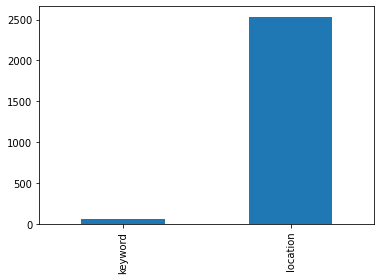

In [35]:


missing = tweet.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()



In [36]:
EMOJIS = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}
URLPATTERN        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"

In [37]:
def preprocessing(text):
  ### Replacing URL
    text = re.sub(URLPATTERN,' URL',text)
    ### Replacing EMOJI
    for emoji in EMOJIS.keys():
        text = text.replace(emoji, "EMOJI" + EMOJIS[emoji])
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

In [38]:
# remove stopwords
nltk.download('stopwords')

stop = set(stopwords.words("english"))

def remove_stopwords(text):
    filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(filtered_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:
tweet["text"] = tweet.text.map(preprocessing)

In [40]:
tweet["text"] = tweet.text.map(remove_stopwords)

In [41]:
tweet.head(15)

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1
5,8,NaN,NaN,rockyfire update california hwy 20 closed dire...,1
6,10,NaN,NaN,flood disaster heavy rain causes flash floodin...,1
7,13,NaN,NaN,im top hill see fire woods,1
8,14,NaN,NaN,theres emergency evacuation happening building...,1
9,15,NaN,NaN,im afraid tornado coming area,1


In [42]:
from collections import Counter


In [43]:
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count


vocabulary = counter_word(tweet.text)

In [44]:
vocab_size = 10000

truncated_vocabulary = [
word for word, count in vocabulary.most_common()[:vocab_size]]

In [45]:
vocabulary.most_common()[:3]

[('url', 4715), ('like', 345), ('im', 299)]

In [46]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [47]:
table.lookup(tf.constant(["This movie was faaaaaantastic".split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[10745,   169, 10637, 10053]])>

In [48]:
X = tf.strings.split(tweet.text) #ragged tensor
X = X.to_tensor(default_value=b"<pad>")

In [49]:
X

<tf.Tensor: shape=(7613, 25), dtype=string, numpy=
array([[b'deeds', b'reason', b'earthquake', ..., b'<pad>', b'<pad>',
        b'<pad>'],
       [b'forest', b'fire', b'near', ..., b'<pad>', b'<pad>', b'<pad>'],
       [b'residents', b'asked', b'shelter', ..., b'<pad>', b'<pad>',
        b'<pad>'],
       ...,
       [b'm194', b'0104', b'utc5km', ..., b'<pad>', b'<pad>', b'<pad>'],
       [b'police', b'investigating', b'ebike', ..., b'<pad>', b'<pad>',
        b'<pad>'],
       [b'latest', b'homes', b'razed', ..., b'<pad>', b'<pad>', b'<pad>']],
      dtype=object)>

In [50]:
def encode_words(X_batch):
  return table.lookup(X_batch)

In [51]:

X = encode_words(X)
y = tweet.target

In [52]:
X

<tf.Tensor: shape=(7613, 25), dtype=int64, numpy=
array([[ 4371,   716,   151, ..., 10403, 10403, 10403],
       [   99,     4,   133, ..., 10403, 10403, 10403],
       [ 1575,  1450,  1968, ..., 10403, 10403, 10403],
       ...,
       [ 3180,  4363,  6578, ..., 10403, 10403, 10403],
       [   17,   988,  3020, ..., 10403, 10403, 10403],
       [  117,   113,   425, ..., 10403, 10403, 10403]])>

In [57]:

#X_train, X_val , y_train, y_val = train_test_split(X, y, test_size=0.2)

In [56]:
embed_size = 120 #vector dimension to embed words
model = keras.models.Sequential([
keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
input_shape=[None]),
keras.layers.GRU(128, return_sequences=True),
keras.layers.GRU(128),
keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam",
metrics=["accuracy"])
history = model.fit(X,y, epochs=5)

Epoch 1/5
238/238 [==============================] - 36s 120ms/step - loss: 0.6147 - accuracy: 0.6507
Epoch 2/5
238/238 [==============================] - 31s 132ms/step - loss: 0.3736 - accuracy: 0.8441
Epoch 3/5
238/238 [==============================] - 20s 83ms/step - loss: 0.2499 - accuracy: 0.9062
Epoch 4/5
238/238 [==============================] - 17s 73ms/step - loss: 0.1708 - accuracy: 0.9393
Epoch 5/5
238/238 [==============================] - 18s 75ms/step - loss: 0.1046 - accuracy: 0.9607


In [64]:
ids = tweet_test["id"]
tweet_test["text"] = tweet_test.text.map(preprocessing)
tweet_test["text"] = tweet_test.text.map(remove_stopwords)
X_test = (tf.strings.split(tweet_test.text)).to_tensor(default_value=b"<pad>")


In [66]:

X_test = encode_words(X_test)

In [67]:
X_test

<tf.Tensor: shape=(3263, 23), dtype=int64, numpy=
array([[  762,  1778,    52, ..., 10403, 10403, 10403],
       [  341,   151,  1040, ..., 10403, 10403, 10403],
       [   99,     4,   675, ..., 10403, 10403, 10403],
       ...,
       [  817,   590,   237, ..., 10403, 10403, 10403],
       [ 6061,   462,   357, ..., 10403, 10403, 10403],
       [ 5745,  2612,  1440, ..., 10403, 10403, 10403]])>

In [68]:
y_test = model.predict(X_test)

In [70]:
y_test

array([[0.92129326],
       [0.7576381 ],
       [0.9947524 ],
       ...,
       [0.9993633 ],
       [0.9858768 ],
       [0.98277223]], dtype=float32)

In [79]:
y_test.shape

(3263, 1)

In [81]:
y_test = y_test.reshape(-1)

In [88]:
y_test = np.round_(y_test). astype(int)

In [84]:
y_test

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [86]:
(unique, counts) = np.unique(y_test, return_counts=True)
(unique, counts)

(array([0., 1.], dtype=float32), array([1819, 1444]))

In [60]:
ids

0           0
1           2
2           3
3           9
4          11
        ...  
3258    10861
3259    10865
3260    10868
3261    10874
3262    10875
Name: id, Length: 3263, dtype: int64

In [87]:
output = pd.DataFrame({'id': ids, 'target': y_test})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
